Evan miller используем для расчета семпла
https://www.evanmiller.org/ab-testing/sample-size.html

Какой мимнимальный эффект нам интересен? Интересно сделать меньший sample size но получить больший эффект. А также необходимо настроить ошибку первого рода. 
- И это наши критерии успешности.


In [1]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [2]:
import pandas as pd
import numpy as np

Загружаем нужные библиотеки

In [3]:
#какой эффект хотим получить
mde = 0.05
#Наши изначальные проценты
baseline = 0.2
#Выборка по версии Эвана Миллера
sample_size = 1030

## Тесты которые можно проводить

Fisher exact test

Z test == Chi square test

T test

Bootstrap (Monte-Carlo)

# Z-test

In [4]:
from statsmodels.stats.proportion import proportions_ztest

Н0: разницы между группами нет == выборки пришли из одного распределения

In [5]:
from tqdm.notebook import tqdm

Получаем p-value 

In [6]:
result = []
#в range = регулируем точность
for _ in tqdm(range(10000)):
    # генерируем рандомные числа, относительно данных, которые имеем
    a = np.random.binomial(1, baseline, size =sample_size)
    # генерируем рандомные числа, относительно данных, которые имеем + наш эффект
    b = np.random.binomial(1, baseline + mde, size =sample_size)
    _, pval = proportions_ztest([a.sum(), b.sum()], [len(b)])
    result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

p-value должен быть меньше чем 0,05

Строим гистограмму по нашим значениям

<AxesSubplot:>

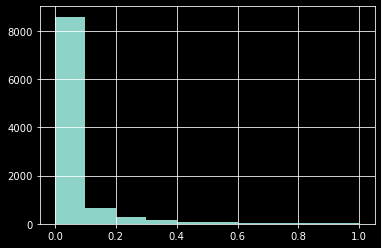

In [7]:
t = pd.Series(result)
t.hist()

Находим мощность нашей выборки:

In [8]:
(t < 0.05).mean()

0.7744

# T- Test

In [9]:
from scipy.stats import ttest_ind

In [10]:
result = []
#в range = регулируем точность
for _ in tqdm(range(10000)):
    # генерируем рандомные числа, относительно данных, которые имеем
    a = np.random.binomial(1, baseline, size =sample_size)
    # генерируем рандомные числа, относительно данных, которые имеем + наш эффект
    b = np.random.binomial(1, baseline + mde, size =sample_size)
    _, pval = ttest_ind(a, b, equal_var=False)
    result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

Выдает ту же мощность, поэтому здесь юзают Z-test или Chiквадрат

In [11]:
t = pd.Series(result)
(t < 0.05).mean()

0.7719

In [13]:
from scipy.stats import mannwhitneyu

In [18]:
result = []
for _ in tqdm(range(10000)):
    a = np.random.binomial(1, baseline, size =sample_size)
    b = np.random.binomial(1, baseline, size =sample_size)
    _, pval = mannwhitneyu(a,b)
    result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
t = pd.Series(result)

In [20]:
(t < 0.05).mean()

0.0491

Мы сделали А/А тест и проверяем равномерность распределения

<AxesSubplot:>

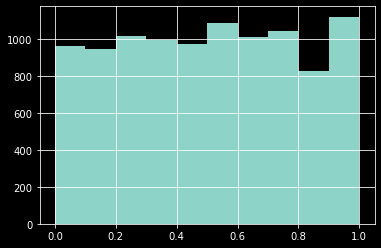

In [22]:
t.hist()

In [23]:
import seaborn as sns

Здесь должна быть прямая линия

<AxesSubplot:ylabel='Proportion'>

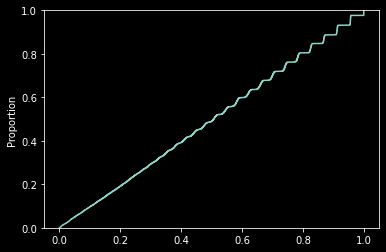

In [24]:
sns.ecdfplot(t)

In [25]:
(t < 0.05).mean()

0.0491

Проверим на пропорциональном тесте, и здесь лучше использовать вот эту схему

In [26]:
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1,baseline,size=sample_size)
  b = np.random.binomial(1,baseline,size=sample_size)
  _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [31]:
t = pd.Series(result)

<AxesSubplot:>

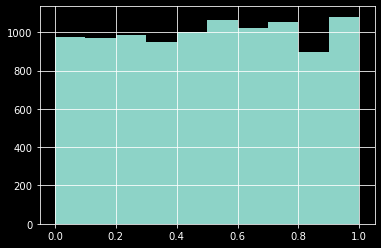

In [32]:
t.hist()

<AxesSubplot:ylabel='Proportion'>

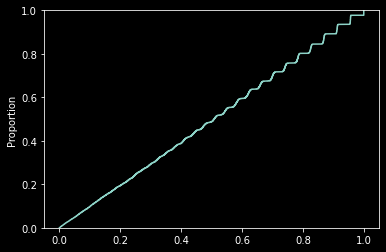

In [33]:
sns.ecdfplot(t)

In [34]:
(t < 0.05).mean()

0.0481

# Сэмплы в питоне

https://colab.research.google.com/drive/10DkHtLXsRHYSB7f5LMV5h5WW__uTcNHE?usp=sharing

In [35]:
import statsmodels.stats.api as sms
#Вот такие эффекты хоти возыметь
es = sms.proportion_effectsize(0.20, 0.25)
# Вот, а здесь есть power и alpha -это было и по ссылке в калькуляторе внизу значения
sample_size = round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))

Получилось немного больше чем мы ожидали

In [36]:
sample_size

1092

In [37]:
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1,baseline,size=sample_size)
  b = np.random.binomial(1,baseline + mde,size=sample_size)
  _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [38]:
t = pd.Series(result)

Получили ровно 80 - что классно

In [39]:
(t < 0.05).mean()

0.7997

А если отношение контроля с тестом  1/3

In [40]:
import statsmodels.stats.api as sms
es = sms.proportion_effectsize(0.20, 0.25)
# Ставим ratio = 1/3
sample_size1 = round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1/3))

Получаем две разные группы:

In [41]:
sample_size1

2184

In [42]:
sample_size2 = round(sample_size1 * 1/3)

In [43]:
sample_size2

728

In [44]:
result = []
for _ in tqdm(range(10000)):
  a = np.random.binomial(1,baseline,size=sample_size1)
  b = np.random.binomial(1,baseline + mde,size=sample_size2)
  _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
  result.append(pval)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
t = pd.Series(result)

Получаем тот же результат

In [46]:
(t < 0.05).mean()

0.7979

# Сэмпл-сайз методом подбора

In [60]:
sample_size = 8392
baseline = 0.3
mde = 0.02

result = []
for _ in tqdm(range(1000)):
  a = np.random.binomial(1,baseline,size=sample_size)
  b = np.random.binomial(1,baseline + mde,size=sample_size)
  _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
  result.append(pval)
    
t = pd.Series(result)
(t < 0.05).mean()

  0%|          | 0/1000 [00:00<?, ?it/s]

0.797

In [61]:
import statsmodels.stats.api as sms
es = sms.proportion_effectsize(0.30, 0.32)
# Ставим ratio = 1/3
(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))

8392.38536140766

In [62]:
 sample_size = 8393
baseline = 0.3
mde = 0.02
result = []
for _ in tqdm(range(1000)):
  a = np.random.binomial(1,baseline,size=sample_size)
  b = np.random.binomial(1,baseline + mde,size=sample_size)
  _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
  result.append((1,pval))

  0%|          | 0/1000 [00:00<?, ?it/s]

# Проверка на датасете

In [64]:
t = pd.DataFrame(result,columns=['y_true','y_score'])

In [65]:
t['y_pred'] = (t['y_score'] < 0.05)*1

In [66]:
t

,y_true,y_score,y_pred
0,1,0.000251,1
1,1,0.036260,1
2,1,0.494448,0
3,1,0.001162,1
4,1,0.006766,1
...,...,...,...
995,1,0.000721,1
996,1,0.000018,1
997,1,0.000192,1
998,1,0.068834,0


In [67]:
t['y_pred'].mean()

0.794

In [68]:
sample_size = 8393
baseline = 0.3
mde = 0.02
result = []
for _ in tqdm(range(1000)):
  a = np.random.binomial(1,baseline,size=sample_size)
  b = np.random.binomial(1,baseline,size=sample_size)
  _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
  result.append((0,pval))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
t = pd.DataFrame(result,columns=['y_true','y_score'])

In [75]:
t['y_pred'] = (t['y_score'] < 0.05)*1

In [76]:
t

,y_true,y_score,y_pred
0,0,0.673197,0
1,0,0.479521,0
2,0,0.428248,0
3,0,0.919451,0
4,0,0.284041,0
...,...,...,...
995,0,0.736313,0
996,0,0.879179,0
997,0,0.053064,0
998,0,0.813297,0


In [77]:
t['y_pred'].mean()

0.049

# Миксуем успешный эксперемент или не успешный

In [78]:
sample_size = 1090
baseline = 0.2
mde = 0.05


result = []
class_balance = 0.5


for _ in tqdm(range(10000)):
#     неуспешные эксперементы без mde
  if np.random.binomial(1,class_balance):
    a = np.random.binomial(1,baseline,size=sample_size)
    b = np.random.binomial(1,baseline,size=sample_size)
    _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
    result.append((0,pval))
    
    
  else:
    #     успешные эксперементы mde
    a = np.random.binomial(1,baseline,size=sample_size)
    b = np.random.binomial(1,baseline + mde,size=sample_size)
    _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
    result.append((1,pval))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [79]:
t = pd.DataFrame(result,columns=['y_true','y_score'])

In [82]:
t['y_pred'] = (t['y_score'] < 0.05)*1

In [83]:
t['y_true'].mean()

0.4941

In [84]:
t

,y_true,y_score,y_pred
0,1,0.000683,1
1,1,0.014888,1
2,0,0.112294,0
3,1,0.039842,1
4,1,0.000721,1
...,...,...,...
9995,1,0.000581,1
9996,0,0.708042,0
9997,1,0.077958,0
9998,1,0.002406,1


In [85]:
from sklearn.metrics import classification_report

In [86]:
# recall - мощность (alpha, power) 
# precision (успешность)
print(classification_report(t['y_true'],t['y_pred']))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88      5059
           1       0.94      0.80      0.86      4941

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [88]:
t[t['y_pred'] == 1]['y_true'].mean()

0.940234281616065

# Изменим баланс классов

In [93]:
sample_size = 1090
baseline = 0.2
mde = 0.05
result = []
class_balance = 0.95
for _ in tqdm(range(10000)):
  if np.random.binomial(1,class_balance):
    a = np.random.binomial(1,baseline,size=sample_size)
    b = np.random.binomial(1,baseline,size=sample_size)
    _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
    result.append((0,pval))
  else:
    a = np.random.binomial(1,baseline,size=sample_size)
    b = np.random.binomial(1,baseline + mde,size=sample_size)
    _, pval = proportions_ztest([a.sum(),b.sum()],[len(a),len(b)])
    result.append((1,pval))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [94]:
t = pd.DataFrame(result,columns=['y_true','y_score'])

In [95]:
t['y_pred'] = (t['y_score'] < 0.05)*1
t['y_true'].mean()

0.0511

In [96]:
print(classification_report(t['y_true'],t['y_pred']))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9489
           1       0.45      0.76      0.56       511

    accuracy                           0.94     10000
   macro avg       0.72      0.85      0.77     10000
weighted avg       0.96      0.94      0.95     10000

